In [7]:
# Carregando dígitos MNIST:
from keras.datasets.mnist import load_data
(digitos_treino, classes_treino), (digitos_teste, classes_teste) = load_data()

In [13]:
import tensorflow as tf

print("Versão do TensorFlow:", tf.__version__)
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

# Verifica se o TensorFlow está realmente usando a GPU
if tf.config.list_physical_devices('GPU'):
    print("Keras está rodando na GPU!")
else:
    print("Keras está rodando na CPU.")

Versão do TensorFlow: 2.17.0
GPUs disponíveis: []
Keras está rodando na CPU.


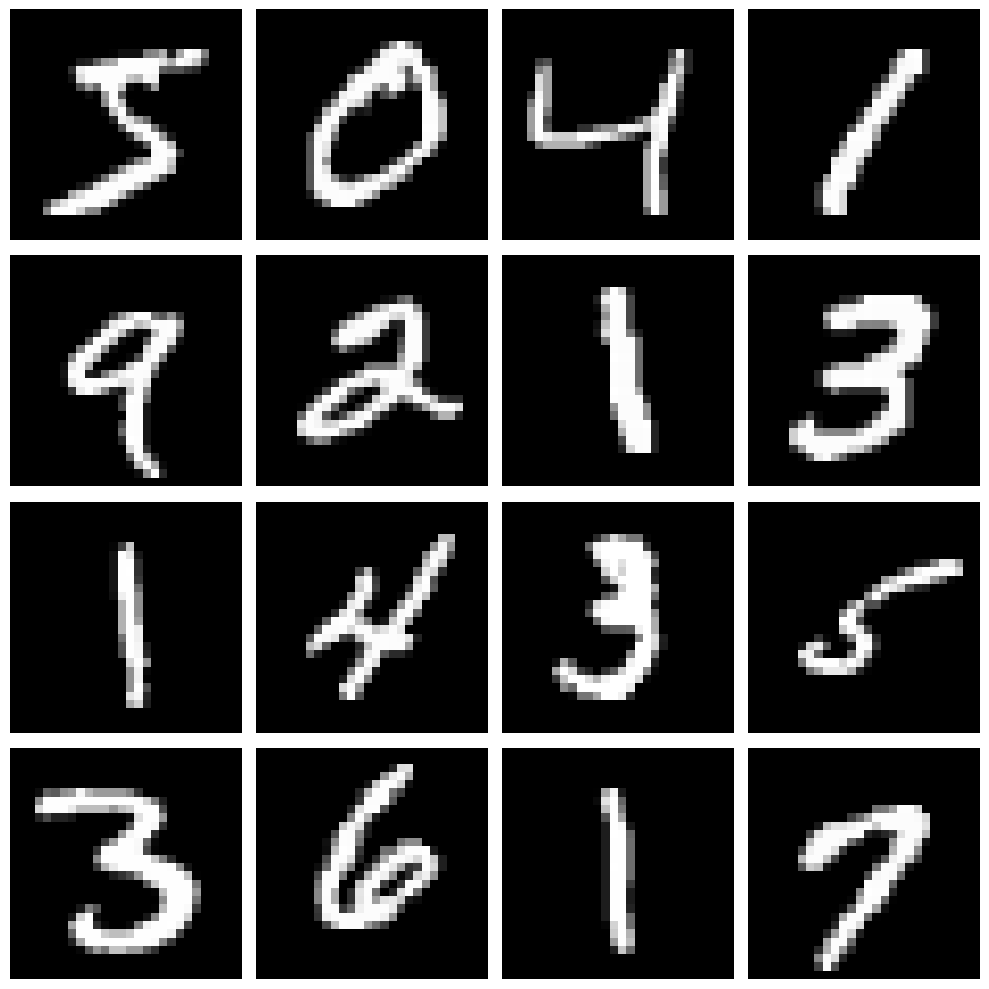

In [8]:
# Conferindo o dataset coletado:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(digitos_treino[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
digitos_treino.shape[0]

60000

In [10]:
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

altura = digitos_treino.shape[1]  
largura = digitos_treino.shape[2]
num_channels = 1  # imagens grayscale

digitos_treino = digitos_treino/127.5 - 1.0

# Adicionando uma dimensão extra de profundidade (de tamanho 1, grayscale):
x_treino = np.reshape(digitos_treino, (digitos_treino.shape[0], altura, largura, num_channels))

# Normalizando os dados:
x_treino = x_treino.astype('float32')

In [11]:
# Criando a classe de modelos Deep Convolutional GAN:
class Modelos_DCGAN(object):
    def __init__(self, altura=28, largura=28, channels=1):

        self.altura = altura
        self.largura = largura
        self.channels = channels
        self.esqueleto_D = None  # discriminator 
        self.esqueleto_G = None # generator
        self.modelo_A = None  # adversarial
        self.modelo_D = None # discriminator

    def esqueleto_discriminator(self):
        if self.esqueleto_D: # se já foi criado uma vez, não precisa criar de novo
            return self.esqueleto_D
        
        # Criando o esqueleto da CNN Discriminator:
        self.esqueleto_D = Sequential()
        dropout = 0.4

        input_shape = (self.altura, self.largura, self.channels)
        self.esqueleto_D.add(Conv2D(filters=64, kernel_size=5, strides=2, input_shape=input_shape, padding='same'))
        self.esqueleto_D.add(LeakyReLU(alpha=0.2)) # o paper original de 2013 usa Relu, mas alguns papers mais modernos dizem que LeakyRelu funcionou melhor empiricamente, especialmente com imagens de maior resolução
        self.esqueleto_D.add(Dropout(dropout))

        self.esqueleto_D.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
        self.esqueleto_D.add(LeakyReLU(alpha=0.2))
        self.esqueleto_D.add(Dropout(dropout))

        self.esqueleto_D.add(Conv2D(filters=256, kernel_size=5, strides=2, padding='same'))
        self.esqueleto_D.add(LeakyReLU(alpha=0.2))
        self.esqueleto_D.add(Dropout(dropout))

        self.esqueleto_D.add(Conv2D(filters=512, kernel_size=5, strides=1, padding='same'))
        self.esqueleto_D.add(LeakyReLU(alpha=0.2))
        self.esqueleto_D.add(Dropout(dropout))

        self.esqueleto_D.add(Flatten())
        self.esqueleto_D.add(Dense(1))
        self.esqueleto_D.add(Activation('sigmoid'))
        return self.esqueleto_D

    def esqueleto_generator(self):
        if self.esqueleto_G:
            return self.esqueleto_G
        self.esqueleto_G = Sequential()
        dropout = 0.4
        profundidade = 256
        lado = 7
        
        # O objetivo é finalizar tudo com uma dimensão de 28 x 28 x 1
        # Primeiro criaremos um vetor de neurônios cujo tamanho permita fazer um reshape de saída de 7 x 7 x 256
        self.esqueleto_G.add(Dense(lado*lado*profundidade, input_dim=100)) # usa-se input_dim quando a entrada é um escalar de dimensão 1. Uma alternativa seria usar input_shape=(100,)
        self.esqueleto_G.add(BatchNormalization(momentum=0.9))
        self.esqueleto_G.add(Activation('relu'))
        self.esqueleto_G.add(Reshape((lado, lado, profundidade))) # a saída atual está 7 x 7 x 256
        self.esqueleto_G.add(Dropout(dropout))

        self.esqueleto_G.add(UpSampling2D(size=(2, 2))) # a saída passou a ser 14 x 14 x 256
        self.esqueleto_G.add(Conv2DTranspose(filters=128, kernel_size=5, padding='same')) # a saída passou a ser 14 x 14 x 128 (obs: padding='same' adiciona uma camada de zeros tal que as dimensões de saída sejam iguais às de entrada)
        self.esqueleto_G.add(BatchNormalization(momentum=0.9))
        self.esqueleto_G.add(Activation('relu'))

        self.esqueleto_G.add(UpSampling2D()) # a saída passou a ser 28 x 28 x 128
        self.esqueleto_G.add(Conv2DTranspose(filters=64, kernel_size=5, padding='same')) # a saída passou a ser 28 x 28 x 64
        self.esqueleto_G.add(BatchNormalization(momentum=0.9))
        self.esqueleto_G.add(Activation('relu'))

        self.esqueleto_G.add(Conv2DTranspose(filters=32, kernel_size=5, padding='same')) # a saída passou a ser 28 x 28 x 32
        self.esqueleto_G.add(BatchNormalization(momentum=0.9))
        self.esqueleto_G.add(Activation('relu'))

        self.esqueleto_G.add(Conv2DTranspose(filters=1, kernel_size=5, padding='same')) # a saída passou a ser 28 x 28 x 1
        self.esqueleto_G.add(Activation('tanh')) # cada pixel de saída ficará entre o range (0, 1)
        return self.esqueleto_G

    def modelo_discriminator(self): # adiciona o otimizador e a função de custo a partir do esqueleto discriminador já montado
        if self.modelo_D:
            return self.modelo_D
        optimizer = RMSprop(learning_rate=0.0002, decay=6e-8)
        self.modelo_D = Sequential()
        self.modelo_D.add(self.esqueleto_discriminator())
        self.modelo_D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.modelo_D # Modelo Discriminator pronto, recebe uma entrada 28 x 28 x 1 e retorna uma prob. entre 0 e 1

    def modelo_adversarial(self): # adiciona o otimizador e a função de custo a partir dos esqueletos generator e discriminator
        if self.modelo_A:
            return self.modelo_A
        optimizer = RMSprop(learning_rate=0.0001, decay=3e-8)
        self.modelo_A = Sequential()
        self.modelo_A.add(self.esqueleto_generator())
        self.modelo_A.add(self.esqueleto_discriminator())
        self.modelo_A.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.modelo_A

# Criando a classe DCGAN completa:
class DCGAN(object):
    def __init__(self, altura=28, largura=28, channels=1, x_treino=None):
        self.altura = altura
        self.largura = largura
        self.channels = channels

        self.x_treino = x_treino

        self.modelos_DCGAN = Modelos_DCGAN(altura=altura, largura=largura, channels=channels)
        self.discriminator =  self.modelos_DCGAN.modelo_discriminator()
        self.adversarial = self.modelos_DCGAN.modelo_adversarial()
        self.generator = self.modelos_DCGAN.esqueleto_generator()
        
    # Função que congela os pesos do discriminator durante o treinamento:
    def discriminator_trainable(self, val): # recebe True ou False
        self.discriminator.trainable = val
        for l in self.discriminator.layers:
            l.trainable = val

    # Função que realiza os treinamentos de ambos os modelos:
    def train(self, train_steps=5000, batch_size=250, intervalo_mostra_imagens=1000):

        for i in range(train_steps):
            imagens_reais = self.x_treino[np.random.randint(0, self.x_treino.shape[0], size=batch_size), :, :, :] # selecionando aleatoriamente imagens de x_treino, uma quantidade batch_size de imagens
            ruidos = np.random.uniform(-1.0, 1.0, size=[batch_size, 100]) # criando uma quantidade batch_size de ruídos
            imagens_fake = self.generator.predict(ruidos) # passando cada um desses ruídos pelo modelo generator para criar as imagens fake
            x = np.concatenate((imagens_reais, imagens_fake)) # agrupando ambas as imagens reais e fake em uma única variável
            
            # Criando um vetor y do tamanho de x com 1's e 0's (as imagens reais serão marcadas com 1 e as fake com 0):
            y = np.ones([2*batch_size, 1])  
            y[batch_size:, :] = 0
            
            # Treinando a rede discriminadora e coletando seu loss atual:
            self.discriminator_trainable(True)
            loss_discriminator = self.discriminator.train_on_batch(x, y) # treina a rede discriminadora no conjunto de dados informado, retornando o loss

            # Treinando a rede adversarial e coletando seu loss atual:
            y = np.ones([batch_size, 1])
            ruidos = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            self.discriminator_trainable(False)
            loss_adversarial = self.adversarial.train_on_batch(ruidos, y)
            
            # Mostrando na tela a evolução do treinamento (loss e acurácia de ambos os modelos):
            if i%100==0:    
                print('%d: [Discriminator loss: %f, acc: %f]   [Adversarial loss: %f, acc: %f]'  % (i, loss_discriminator[0], 
                                                                                                loss_discriminator[1], 
                                                                                                loss_adversarial[0], 
                                                                                                loss_adversarial[1]))
            # Mostrando na tela algumas imagens fake geradas:
            if (i+1)%intervalo_mostra_imagens==0:
                ruido_de_entrada = np.random.uniform(-1.0, 1.0, size=[16, 100]) # criando num_amostras de ruído para mostrar na tela
                self.plot_images(num_amostras=ruido_de_entrada.shape[0], noise=ruido_de_entrada)

    # Função que plota imagens reais ou fake na tela:
    def plot_images(self, fake=True, num_amostras=16, noise=None):
        if fake: # se quer mostrar imagens fake geradas:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[num_amostras, 100])
            imagens = self.generator.predict(noise)
        else: # se quer mostrar imagens reais, mostre aleatoriamente num_amostras imagens reais de x_treino:
            i = np.random.randint(0, self.x_treino.shape[0], num_amostras)
            imagens = self.x_treino[i, :, :, :]

        # Mostrando as imagens com subplot:
        plt.figure(figsize=(10,10))
        for i in range(imagens.shape[0]):
            plt.subplot(4, 4, i+1)
            imagem = imagens[i, :, :, :]
            imagem = np.reshape(imagem, [self.altura, self.largura]) # coloca a imagem em duas dimensões somente
            imagem = (imagem+1)*127.5
            plt.imshow(imagem, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [12]:
# Rodando o modelo:

gan = DCGAN(altura=28, largura=28, channels=1, x_treino=x_treino) # instanciando a classe
gan.train(train_steps=10000, batch_size=256, intervalo_mostra_imagens=1000) # treinando

c:\Users\Matheus\Desktop\Matheus\Programming\Python\MachineLearning\venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Users\Matheus\Desktop\Matheus\Programming\Python\MachineLearning\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Matheus\Desktop\Matheus\Programming\Python\MachineLearning\venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\Matheus\Desktop\Matheus\Programming\Python\MachineLearning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pas

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
0: [Discriminator loss: 0.698149, acc: 0.488281]   [Adversarial loss: 0.601221, acc: 1.000000]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


KeyboardInterrupt: 

In [ ]:
# Mostrando os resultados finais:
gan.plot_images(fake=True) 